<img src="mioti.png" style="height: 100px">
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Data preprocessing</center>

# Challenge S7: Clasificación de sentimientos en tweets

<font size="5"><center><span style="color:blue">***Nombre y Apellidos: Sergi Julià***</span></center></font>

## Objetivos:

El objetivo de este challenge es enfrentarse a un problema de clasificación de texto real: tweets descargados sobre las elecciones de EEUU en 2016, centrándonos en el preprocesamiento, que en este caso es crucial en un problema en el que el protagonista es el texto.

## Inicialización del entorno:

In [3]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk.tokenize import word_tokenize
from nltk import pos_tag

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import random
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

random.seed(1234)
pd.set_option('display.max_colwidth', 175) # incrementamos anchura de output

In [4]:
df_train = pd.read_csv('./data/gop_tweets_train_psn.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8414 entries, 0 to 8413
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  8414 non-null   object
 1   text       8414 non-null   object
dtypes: object(2)
memory usage: 131.6+ KB


In [5]:
df_test = pd.read_csv('./data/gop_tweets_test_psn.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2153 entries, 0 to 2152
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  2153 non-null   object
 1   text       2153 non-null   object
dtypes: object(2)
memory usage: 33.8+ KB


Damos un vistazo a los textos que aparecen en el dataset.

In [4]:
df_train.head()

,sentiment,text
0,Neutral,RT @NancyLeeGrahn: How did everyone feel about the Climate Change question last night? Exactly. #GOPDebate
1,Positive,RT @ScottWalker: Didn't catch the full #GOPdebate last night. Here are some of Scott's best lines in 90 seconds. #Walker16 http://t.co/ZSfF…
2,Neutral,RT @TJMShow: No mention of Tamir Rice and the #GOPDebate was held in Cleveland? Wow.
3,Positive,RT @RobGeorge: That Carly Fiorina is trending -- hours after HER debate -- above any of the men in just-completed #GOPdebate says she's on …
4,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump delivered the highest ratings in the history of presidential debates. #Trump2016 http://t.co…


In [5]:
df_test.head()

,sentiment,text
0,Positive,"RT @GregAbbott_TX: @TedCruz: ""On my first day I will rescind every illegal executive action taken by Barack Obama."" #GOPDebate @FoxNews"
1,Neutral,Going on #MSNBC Live with @ThomasARoberts around 2 PM ET. #GOPDebate
2,Positive,RT @WayneDupreeShow: Just woke up to tweet this out #GOPDebate \r\n\r\nBest line of the night via @GovMikeHuckabee http://t.co/6OV5hxHIcV
3,Negative,reason comment is funny 'in case you're ignorant' is the #gop #tcot are the reason the government isn't working for the people #gopdebate
4,Positive,"RT @ChuckNellis: Cruz has class &amp; truth, that gets my vote! #GOPDebate"


## ¿Qué número de tweets tenemos en cada dataset? ¿Cuántos de cada clase?

In [6]:
df_test['sentiment'].value_counts()

Negative    1257
Neutral      567
Positive     329
Name: sentiment, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


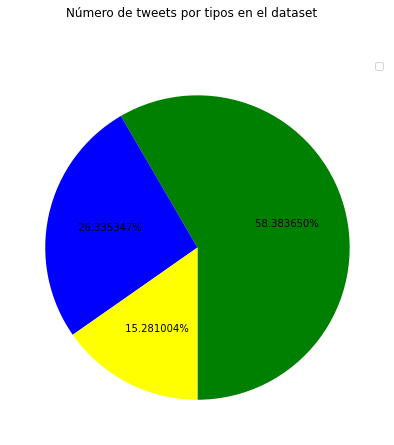

In [7]:
fig, ax = plt.subplots(figsize=(7,7))

Negative = df_test['sentiment'].value_counts()['Negative']
Neutral = df_test['sentiment'].value_counts()['Neutral']
Positive = df_test['sentiment'].value_counts()['Positive']

*_, texts = ax.pie(
    (Negative, Neutral, Positive),
    autopct=lambda p: f'{p: 2f}%',
    colors=['Green', 'Blue', 'Yellow'],
    startangle=270
)

for text, color in zip(texts, ['Black']):
    text.set_color(color)

plt.legend()
    
fig.suptitle('Número de tweets por tipos en el dataset');

In [8]:
df_train['sentiment'].value_counts()

Negative    4872
Neutral     2162
Positive    1380
Name: sentiment, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


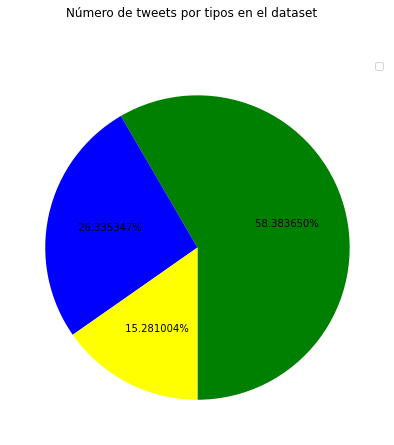

In [9]:
fig, ax = plt.subplots(figsize=(7,7))

Negative_t = df_train['sentiment'].value_counts()['Negative']
Neutral_t = df_train['sentiment'].value_counts()['Neutral']
Positive_t = df_train['sentiment'].value_counts()['Positive']

*_, texts = ax.pie(
    (Negative, Neutral, Positive),
    autopct=lambda p: f'{p: 2f}%',
    colors=['Green', 'Blue', 'Yellow'],
    startangle=270
)

for text, color in zip(texts, ['Black']):
    text.set_color(color)

plt.legend()
    
fig.suptitle('Número de tweets por tipos en el dataset');

## ¿Qué dificultades crees que presenta la diferencia entre la cantidad de clases?

Que en ambos casos más del 50% de los comentarios son negativos.

## Clasificador de tweets

Vamos a construir nuestro propio clasificador sobre los tweets que hemos cargado. Los pasos que seguiremos serán:

* Preprocesar ambos conjuntos de tweets por separado.
* Entrenar clasificador con tweets de entrenamiento.
* Evaluar con tweets de test.

Primero, haremos una prueba para observar el rendimiento de nuestro clasificador sin ningún tipo de preprocesamiento.

In [6]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

Seguimos creando el clasificador y entrenando con el conjunto de entrenamiento de los tweets.

In [7]:
# creamos nuestro pipeline con vectorizador (bag of words) y clasificador
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('clf', LinearSVC(max_iter=1200))])

# entrenamos el clasificador
text_clf.fit(df_train['text'], df_train['sentiment'])

Pipeline(steps=[('vect', CountVectorizer()), ('clf', LinearSVC(max_iter=1200))])

Realizamos las predicciones con el conjunto de test y obtenemos la métrica de evaluación.

In [8]:
predicted = text_clf.predict(df_test['text'])
np.mean(predicted == df_test['sentiment'])

0.5973060845332094

Parece que hemos obtenido un resultado un poco peor... Ahora es cuando entra en juego el preprocesamiento del texto.

Ahora vamos a preprocesar el texto y construir un clasificador. Para ello, se ha creado esta función que nos automatiza el preprocesamiento. Deberás añadir el código que creas necesario y ejecutar la función para obtener el texto preprocesado. 

**Puedes definir todas las funciones de preprocesado que creas necesario, pero ten en cuenta varios detalles:**
* La funcion `preprocesar_texto` es llamada desde un `apply`. Esto significa que la función recibe un tweet y devuelve un tweet preprocesado con cada llamada. 
* Si el preprocesado es muy agresivo, un tweet puede quedarse fácilmente vacío, en esos casos el clasificador no podrá trabajar con él y escupirá la clase mayoritaria para ese tweet.
* Algunas técnicas no tienen sentido si se aplican después de otras dentro del pipeline. Por ejemplo, no tiene sentido aplicar POS después de realizar Stemming.
* Count Vectorizer necesita DOCUMENTOS y al trabajar con texto muchas veces es más sencillo hacer uso de TOKENS. Esto significa que tendremos que pasar cada tweet preprocesado en una cadena de texto. La función `" ".join(palabras)` que vimos en el worksheet es tu aliada.
* Si tu preprocesamiento va a ser intensivo, quizás es buena idea crear varias funciones que sean llamadas desde `preprocesar_texto`.

In [9]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")

In [10]:
def preprocesar_texto(texto):
    """ Función para preprocesamiento de texto.
    Args:
        texto: cadena de texto a preprocesar.
    Returns:
        mismo texto preprocesado.
    """
    stemmer = SnowballStemmer("english")
    texto_filtrado = ""
    # AQUÍ TU CÓDIGO
    palabras = TweetTokenizer().tokenize(texto)
    
    for i in pos_tag(palabras):
        if i[1].startswith('JJ') or i[1].startswith('VB'):
            texto_filtrado=texto_filtrado+''+i[0] 
    
    for palabra in palabras:
        palabra.append(stemmer.stem(texto_filtrado))
            
   
    
    
    return texto_filtrado

In [ ]:
df_test['text'].apply(preprocesar_texto)

In [77]:
df_train['text'].apply(preprocesar_texto)

0                       last
1             RTfulllastbest
2                           
3             just-completed
4        highestpresidential
                ...         
8409    ear-to-head#Walker16
8410                        
8411                        
8412                        
8413                   Best"
Name: text, Length: 8414, dtype: object

Aplicamos el preprocesamiento a los dos conjuntos de tweets y lo guardamos en la columna `prep`.

In [11]:
df_train['prep'] = df_train['text'].apply(preprocesar_texto)
df_test['prep'] = df_test['text'].apply(preprocesar_texto)

AttributeError: 'str' object has no attribute 'append'

Antes de reentrenar nuestro clasificador, siempre es recomendable dar un vistazo al resultado del texto dentro del dataframe. También observar frecuencia de palabras o simplemente generar un WordCloud.

In [79]:
# AQUÍ TU CÓDIGO
def words(tweet):
    words_t = []
    
    words_t = word_tokenize(tweet)
    
    return words_t

In [80]:
words_t_test = []
for t in df_test['prep'].unique():
    words_t_test.extend(words(t))
    
print('words_t_test:' + str(len(words_t_test)))
print(words_t_test[0:50])
tweet_test = ''.join(words_t_test)

words_t_test:2125
['firstillegal', '#', 'GOPDebate', '#', 'GOPDebate', 'funny', '#', 'gop', 'youngworried', '@', "feministabulousgaywomen'sworseit", "'s", 'FamousPolitical', 'RT', '@', 'kvxrdashianJeb', "''", "''", 'misogynistic', "''", 'politicalpervasive', 'wtf', 'defendfairlast', 'littlereligious', 'firstimpressed', '#', 'GOPDebate', 'RTforeign', '``', 'dial', '#', 'GOPDebate', 'many', 'RTAnti-Gay', 'RTSays', 'did', "n't", 'RT', 'realillegal', '🎀', 'mainstraightwhite', '@', 'BretBaierbad', "''", 'Lastspoiled', '@', 'rushlimbaugh', 'halfintelligible', 'newfox', '…']


In [81]:
words_t_train = []
for t in df_train['prep'].unique():
    words_t_train.extend(words(t))
    
print('words_t_train:' + str(len(words_t_train)))
print(words_t_train[0:50])
tweet_train = ''.join(words_t_train)

words_t_train:6934
['last', 'RTfulllastbest', 'just-completed', 'highestpresidential', 'happyhttps', ':', '//…', 'only', 'Lastnight', "'s", '#', 'GOPDebate', '#', 'BATsAsk', '@', 'JGreenDCfairness', 'great', 'romantic', 'ownpoliticals', '@', 'IWF', 'speaking', '#', 'Ha', 'gladdestroy', 'hatemore', 'RT', '#', 'GOPDebateworst', 'nextlittlewimpy', 'sad', 'FirstSocialMore', '@', 'realDonaldTrump', '#', 'Republican', 'trueamerican', '#', 'BlackLivesMatter', '#', 'GOPDebate', '“', 'highestpresidential', '#', 'Trump2016', 'Most-Tweeted', '#', 'GOPDebatemilitary', "''", 're']


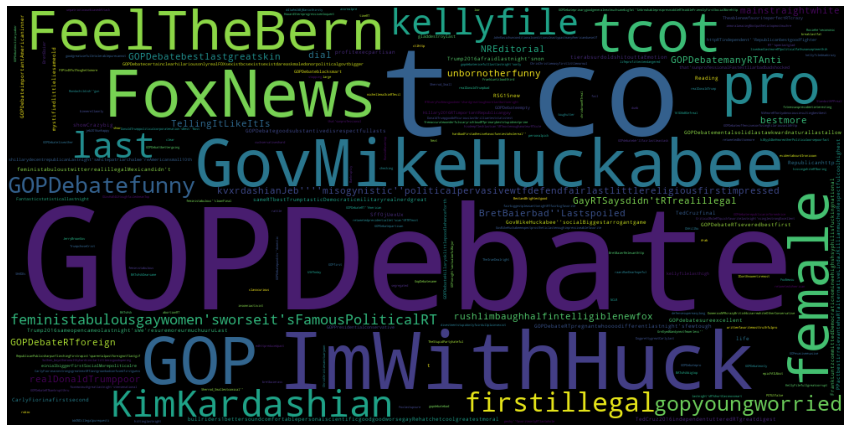

In [72]:
wordcloud = WordCloud(width = 1000, height = 500, relative_scaling = 0.5).generate(tweet_test)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

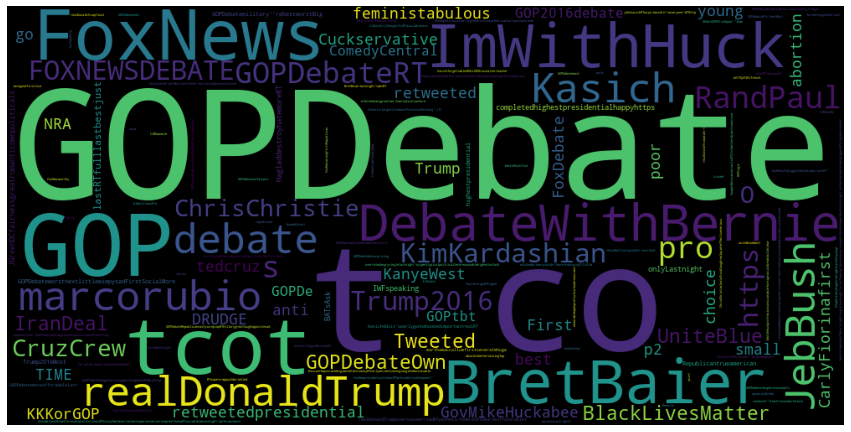

In [73]:
wordcloud = WordCloud(width = 1000, height = 500, relative_scaling = 0.5).generate(tweet_train)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Ahora sí, vamos a reentrenar el clasificador y evaluar de nuevo. Puedes hacer uso del mismo pipeline anterior o simplemente crear uno nuevo con más etapas.

In [22]:
# Nuevo pipeline si es que es necesario. Por defecto usamos el anterior. Recuerda RE-ENTRENAR en cualquier caso!
new_clf = text_clf

In [82]:
# Predicción haciendo uso del pipeline correspondiente. ¡Recuerda cambiarlo si has creado uno nuevo!
predicted = new_clf.predict(df_test['prep'])
np.mean(predicted == df_test['sentiment'])

0.34602879702740363

In [83]:
predicted = new_clf.predict(df_train['prep'])
np.mean(predicted == df_train['sentiment'])

0.3810316139767055

* ¿Qué opinas de los resultados obtenidos?
* ¿Por qué crees que ha sucedido esto?

No me parece suficiente la limpieza, ha sucedido porque no se como añadir más conceptos para depurar, he provado más estratégias pero no me entravan dentro del bucle.

¿Podrías explicarme con tus palabras en qué consiste Tf-Idf? ¿Cual es la idea intuitiva de aplicar esta transformación a la matriz?

Es la medida númerica con la cual se expresa la relevancia de una palabra de un documento en concreto.
La idea de utilizarla vendria a ser para recuperar información y la minería de texto.